In [1]:
import pandas as pd
import numpy as np

# Path to the CSV file
file_path = "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/prune_predictions_norm_off/FlowPruning/pruning_analysis_results.csv"
# Load the CSV file
df = pd.read_csv(file_path)
# Filter rows where fold is 'all'
df_all_fold = df[df['fold'] == 'all']

# Step 1: Add prune_layers length to help with sorting
df_all_fold['prune_layers_length'] = df_all_fold['prune_layers'].str.len()

# Step 2: Separate None and non-None entries
none_rows = df_all_fold[df_all_fold['eliminate_data_flow'].isna()]
non_none_rows = df_all_fold[~df_all_fold['eliminate_data_flow'].isna()]

# Step 3: Keep only the None entry with shortest prune_layers
if not none_rows.empty:
    shortest_none_idx = none_rows['prune_layers_length'].idxmin()
    shortest_none_row = none_rows.loc[[shortest_none_idx]]
else:
    shortest_none_row = pd.DataFrame()

# Step 4: Combine the shortest None row with all non-None rows
df_filtered = pd.concat([shortest_none_row, non_none_rows])

# Step 5: Assign bottleneck_removal values based on groups and prune_layers length
# First, give None a value of 0
df_filtered['bottleneck_removal'] = -1
df_filtered.loc[df_filtered['eliminate_data_flow'].isna(), 'bottleneck_removal'] = 0

# Step 6: For each non-None group, sort by prune_layers length and assign incrementing values
for flow_type in df_filtered['eliminate_data_flow'].dropna().unique():
    # Get indices of rows with this flow_type
    indices = df_filtered[df_filtered['eliminate_data_flow'] == flow_type].index
    # Sort these rows by prune_layers length
    sorted_indices = df_filtered.loc[indices].sort_values('prune_layers_length').index
    # Assign incrementing values starting from 1
    df_filtered.loc[sorted_indices, 'bottleneck_removal'] = np.arange(1, len(sorted_indices) + 1)

# Step 7: Sort by bottleneck_removal and drop temporary column
df_filtered = df_filtered.sort_values(['eliminate_data_flow', 'bottleneck_removal'])
df_filtered = df_filtered.drop(columns=['prune_layers_length'])

# Print the result
print(df_filtered)

   fold prune_method eliminate_data_flow  \
7   all  FlowPruning             decoder   
2   all  FlowPruning             decoder   
3   all  FlowPruning             decoder   
14  all  FlowPruning             decoder   
13  all  FlowPruning             decoder   
1   all  FlowPruning             encoder   
11  all  FlowPruning             encoder   
9   all  FlowPruning             encoder   
8   all  FlowPruning             encoder   
10  all  FlowPruning             encoder   
5   all  FlowPruning                 NaN   

                                         prune_layers  prune_weights  \
7                       decoder.stages.0.convs.0.conv           True   
2   decoder.stages.0.convs.0.conv-decoder.stages.1...           True   
3   decoder.stages.0.convs.0.conv-decoder.stages.1...           True   
14  decoder.stages.0.convs.0.conv-decoder.stages.1...           True   
13  decoder.stages.0.convs.0.conv-decoder.stages.1...           True   
1                       decoder.stages.

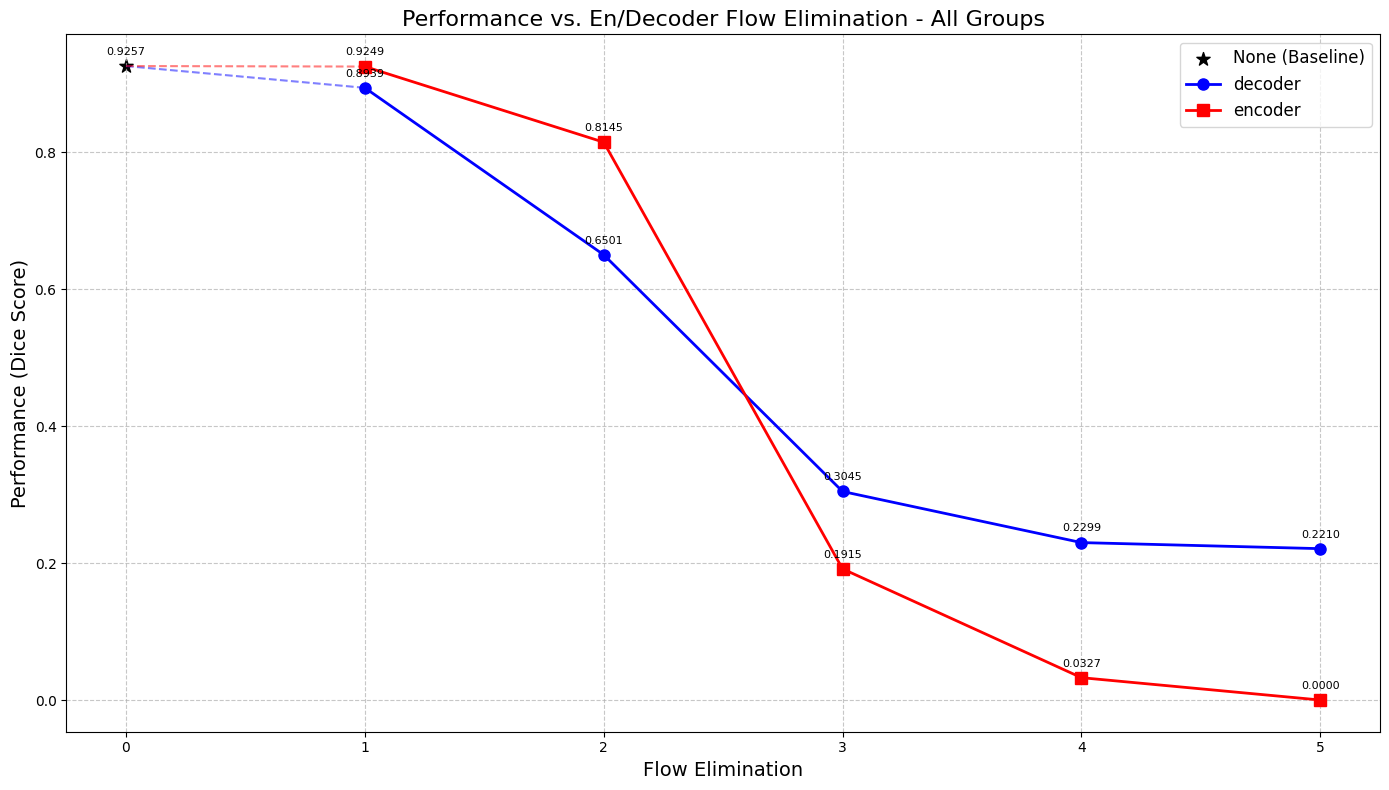

Combined graph has been saved as 'flow_elimination_plots/performance_vs_flow_elimination_all_groups.png'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming df_filtered is already created from previous code
# First, ensure the output directory exists
output_dir = 'flow_elimination_plots'
os.makedirs(output_dir, exist_ok=True)

# Create a combined plot for all groups
plt.figure(figsize=(14, 8))

# Get the None entry
none_entry = df_filtered[df_filtered['bottleneck_removal'] == 0]

# Plot the None entry first (as a reference point)
plt.scatter(none_entry['bottleneck_removal'],
          none_entry['performance_Dice'],
          s=100, c='black', marker='*', label='None (Baseline)')

# Define a color map for different flow types
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
markers = ['o', 's', '^', 'D', 'v', '>', '<']

# Get unique non-None eliminate_data_flow values
unique_flows = df_filtered['eliminate_data_flow'].dropna().unique()

# Plot each group with a different color/marker
for i, flow in enumerate(unique_flows):
    # Get data for this flow type
    flow_data = df_filtered[df_filtered['eliminate_data_flow'] == flow]

    # Sort by bottleneck_removal
    flow_data = flow_data.sort_values('bottleneck_removal')

    # Get color and marker (cycling if more groups than colors)
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]

    # Plot the data
    plt.plot(flow_data['bottleneck_removal'],
             flow_data['performance_Dice'],
             marker=marker, linestyle='-', linewidth=2, markersize=8,
             color=color, label=f'{flow}')

    # Connect to None entry with dashed line
    plt.plot([0, flow_data['bottleneck_removal'].min()],
             [none_entry['performance_Dice'].values[0], flow_data.iloc[0]['performance_Dice']],
             linestyle='--', color=color, alpha=0.5)

# Add labels and title
plt.xlabel('Flow Elimination', fontsize=14)
plt.ylabel('Performance (Dice Score)', fontsize=14)
plt.title('Performance vs. En/Decoder Flow Elimination - All Groups', fontsize=16)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(loc='best', fontsize=12)

# Add annotations for data points
for i, row in df_filtered.iterrows():
    plt.annotate(f"{row['performance_Dice']:.4f}",
                 (row['bottleneck_removal'], row['performance_Dice']),
                 textcoords="offset points",
                 xytext=(0, 8),
                 ha='center',
                 fontsize=8)

# Save the figure
filename = f"{output_dir}/performance_vs_flow_elimination_all_groups.png"
plt.tight_layout()
plt.savefig(filename)
plt.show()

print(f"Combined graph has been saved as '{filename}'")